References to these sources where used in this code: 
https://jeriwieringa.com/2017/06/30/calculating-and-visualizing-topic-significance-over-time-part-3/

In [1]:
import nltk
import pickle5 as pickle
import carmen
from pyarrow import json
import jsonlines
import json_lines
import spacy
import tokenizer
from json2parquet import convert_json
import csv
import ijson
from nltk.tokenize import word_tokenize
import gensim.corpora as corpora
from gensim.models import Phrases, CoherenceModel
from gensim.models.phrases import Phraser
from gensim.models.wrappers import LdaMallet
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import folium
import os
import pyarrow.parquet as pq
import tomotopy as tp
from datetime import datetime

In [2]:
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
# Plotting tools
import pyLDAvis.gensim
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
# %matplotlib inline"

In [3]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
nltk.download('punkt')

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/austingerner/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
import pandas as pd
import numpy as np
import re
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
# Gensim
import gensim
from gensim.utils import simple_preprocess
# NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline
import nltk
from nltk.corpus import stopwords


from nltk import bigrams
from nltk.stem import PorterStemmer

sns.set(font_scale=1.5)
sns.set_style("whitegrid")
import gensim
from gensim import corpora
from pprint import pprint
import warnings 
from plotnine import ggplot, aes, geom_line, geom_histogram, labs, theme_bw, scale_x_continuous, \
                    geom_bar, theme, lims, geom_text, position_dodge
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/austingerner/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

<ipython-input-5-1390d13c0cdd>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


# Building Modeling Table

In [6]:
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import sys

def train_HDPmodel(hdp, word_list, mcmc_iter, burn_in=100, quiet=False):
    '''Wrapper function to train tomotopy HDP Model object
    
    *** Inputs**
    hdp: obj -> initialized HDPModel model
    word_list: list -> lemmatized word list of lists
    mcmc_iter : int -> number of iterations to train the model
    burn_in: int -> MC burn in iterations
    quiet: bool -> flag whether to print iteration LL and Topics, if True nothing prints out
    
    ** Returns**
    hdp: trained HDP Model 
    '''
    
    # Add docs to train
    for vec in word_list:
        hdp.add_doc(vec)

    # Initiate MCMC burn-in 
    hdp.burn_in = 100
    hdp.train(0)
    print('Num docs:', len(hdp.docs), ', Vocab size:', hdp.num_vocabs, ', Num words:', hdp.num_words)
    print('Removed top words:', hdp.removed_top_words)
    print('Training...', file=sys.stderr, flush=True)

    # Train model
    step=round(mcmc_iter*0.10)
    for i in range(0, mcmc_iter, step):
        hdp.train(step, workers=3)
        if not quiet:
            print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, hdp.ll_per_word, hdp.live_k))
        
    print("Done\n")  
    
    return hdp
    
        
def get_hdp_topics(hdp, top_n=10):
    '''Wrapper function to extract topics from trained tomotopy HDP model 
    
    ** Inputs **
    hdp:obj -> HDPModel trained model
    top_n: int -> top n words in topic based on frequencies
    
    ** Returns **
    topics: dict -> per topic, an arrays with top words and associated frequencies 
    '''
    
    # Get most important topics by # of times they were assigned (i.e. counts)
    sorted_topics = [k for k, v in sorted(enumerate(hdp.get_count_by_topics()), key=lambda x:x[1], reverse=True)]

    topics=dict()
    
    # For topics found, extract only those that are still assigned
    for k in sorted_topics:
        if not hdp.is_live_topic(k): continue # remove un-assigned topics at the end (i.e. not alive)
        topic_wp =[]
        for word, prob in hdp.get_topic_words(k, top_n=top_n):
            topic_wp.append((word, prob))

        topics[k] = topic_wp # store topic word/frequency array
        
    return topics



def eval_coherence(topics_dict, word_list, coherence_type='c_v'):
    '''Wrapper function that uses gensim Coherence Model to compute topic coherence scores
    
    ** Inputs **
    topic_dict: dict -> topic dictionary from train_HDPmodel function
    word_list: list -> lemmatized word list of lists
    coherence_typ: str -> type of coherence value to comput (see gensim for opts)
    
    ** Returns **
    score: float -> coherence value
    '''
    
    # Build gensim objects
    vocab = corpora.Dictionary(word_list)
    corpus = [vocab.doc2bow(words) for words in word_list]
    
    # Build topic list from dictionary
    topic_list=[]
    for k, tups in topics_dict.items():
        topic_tokens=[]
        for w, p in tups:
            topic_tokens.append(w)
            
        topic_list.append(topic_tokens)
            

    # Build Coherence model
    print("Evaluating topic coherence...")
    cm = CoherenceModel(topics=topic_list, corpus=corpus, dictionary=vocab, texts=word_list, 
                    coherence=coherence_type)
    
    score = cm.get_coherence()
    print ("Done\n")
    return score
def remove_users(tweet, pattern1, pattern2):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    
    r = re.findall(pattern2, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

def remove_links(tweet):
    tweet_no_link = re.sub(r"http\S+", "", tweet)
    return tweet_no_link

def tokenize(tweet):
    for word in tweet:
        yield(gensim.utils.simple_preprocess(str(word), deacc=True))  # deacc=True Removes punctuations
        
def remove_stopwords(tweets):
    return [[word for word in simple_preprocess(str(tweet)) if word not in stop_words] for tweet in tweets]

# Join the tweet back together
def rejoin_words(row):
    words = row['tokens_no_stop']
    joined_words = (" ".join(words))
    return joined_words

def carmenFormat(tweet_id, text):
    tweetFormatList = []
    carmenTweet = {"tweet": {"text": text, "id": tweet_id}}
    #print(carmenTweet)
    return carmenTweet

        #for tweets in row['text'][index]:
        #tweetFormatList.append({"tweet": {"id": row[],"text": tweet}})
    #for index, row in df.iterrows():

    #return tweetFormatList

def twitterLocation(list):
    tweetList = []
    for tweet in list:
        #print("tweeeet", tweet)
        tweetLocation = resolver.resolve_tweet(tweet)
        tweetList.append(tweetLocation)
    return tweetList
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

def corpusStemmed(x):
    corpus = []
    for tweets in x['stemmed']:
        corpus.append(x['id2word_stemmed'].doc2bow(tweets))
    
    return corpus

def createLDAModel(x):
    mallet_path = '/Users/austingerner/mallet/bin/mallet' # update this path
    ldaMalletModel = gensim.models.wrappers.LdaMallet(mallet_path, corpus=x['hashtag_text'], num_topics=5, id2word=x['hashtags'])

    #for tweets in range(len(x)):
     #print("x", x['corpus_stemmed'][tweets], tweets, x['hashtags'][tweets])
      #ldaMalletModel = gensim.models.wrappers.LdaMallet(mallet_path, corpus=x['corpus_stemmed'][tweets], num_topics=5, id2word=x['id2word_stemmed'][tweets])
       # ldaMalletModel.save("{}-{}.txt".format(tweets, x['hashtags'][tweets]))
    return ldaMalletModel


def lemmatiziation(tweets, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    tweets_out = []
    for sent in tweets:
        doc = nlp(" ".join(sent))
        tweets_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
#     print("tweets_out", tweets_out)
    return tweets_out

def applyLemminzation(x):
#     print("x", x)
    tweet_list = pd.Series(lemmatiziation(x, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']))
    print("tweet_list", tweet_list)

    return tweet_list

def applyStemmer(x):
    for tweets in x:
#         print(tweets, "tweets")
        for tweet in tweets:
            stemmer.stem(tweet)
#     print("Stemmed", x, tweets)
    return x
def stemmerCorporaDictionary(x):
    corpora.Dictionary(x)

    print("corporadict", x)
    return x
# covid_hashtags_sample_preprocessed_df['vector'].iloc[0][0]

def highestRank(x):
    topRank = max(x, key=lambda x: x[1])
    return topRank[0]
def highestDistribution(x):
    topDistribution = max(x, key=lambda x: x[1])
    return topDistribution[1]
        #[stemmer.stem(y) for y in x]


In [7]:
# covid_hashtags_df = pd.read_pickle('august_2020_covid_tweets_preprocessed.pkl')
# covid_hashtags_full_preprocessed_df = covid_hashtags_df.copy()
march_tweets_processed_df = pd.read_pickle("/Users/austingerner/Documents/gw/capstone/preprocessing/data/preprocessed_march_tweets_df.pkl")
april_tweets_processed_df = pd.read_pickle("/Users/austingerner/Documents/gw/capstone/preprocessing/data/preprocessed_april_tweets_df.pkl")
may_tweets_processed_df = pd.read_pickle("/Users/austingerner/Documents/gw/capstone/preprocessing/data/preprocessed_may_tweets_df.pkl")
june_tweets_processed_df = pd.read_pickle("/Users/austingerner/Documents/gw/capstone/preprocessing/data/preprocessed_june_tweets_df.pkl")
july_tweets_processed_df = pd.read_pickle("/Users/austingerner/Documents/gw/capstone/preprocessing/data/preprocessed_july_tweets_df.pkl")
august_tweets_processed_df = pd.read_pickle("/Users/austingerner/Documents/gw/capstone/preprocessing/data/preprocessed_august_tweets_df.pkl")

september_tweets_processed_df = pd.read_pickle("/Users/austingerner/Documents/gw/capstone/preprocessing/data/preprocessed_september_tweets_df.pkl")
october_tweets_processed_df = pd.read_pickle("/Users/austingerner/Documents/gw/capstone/preprocessing/data/preprocessed_october_tweets_df.pkl")

november_tweets_processed_df = pd.read_pickle("/Users/austingerner/Documents/gw/capstone/preprocessing/data/preprocessed_november_tweets_df.pkl")


In [8]:
tweets_processed_df = pd.concat([march_tweets_processed_df, april_tweets_processed_df, may_tweets_processed_df,
                                june_tweets_processed_df, july_tweets_processed_df, august_tweets_processed_df, 
                                september_tweets_processed_df, october_tweets_processed_df, november_tweets_processed_df])

tweets_processed_df = explode(tweets_processed_df, ['hashtags'])

tweets_processed_df['hashtags'] = tweets_processed_df['hashtags'].astype('string')
tweets_processed_df['hashtags'] = tweets_processed_df['hashtags'].str.lower()

covid_full_hashtag_seperated_hashtag_text_dict = tweets_processed_df.groupby('hashtags').text.apply(list).to_dict()

covid_full_hashtag_seperated_hashtag_text_dict = pd.DataFrame(covid_full_hashtag_seperated_hashtag_text_dict.items(), columns = ['hashtags', 'texts'])

##Stemmer

stemmer = PorterStemmer()
tweets_processed_df['stemmed'] = tweets_processed_df['tokens_no_stop'].apply(lambda x : applyStemmer(x))

# HDP Modeling to find range of optimal number topics

In [9]:

tw_list = [tp.TermWeight.ONE, # all terms weighted equally
           tp.TermWeight.PMI, # Pointwise Mutual Information term weighting
           tp.TermWeight.IDF] # down-weights high frequency terms, upweights low freq ones

# tw_names = ['one', 'pmi', 'idf']
tw_names = ['one']

model_topics =[]

hdp = tp.HDPModel(tw=tp.TermWeight.ONE, min_cf=10, gamma=1, alpha=0.1,
                 initial_k=10, seed=99999)

print("Model one" )
hdp = train_HDPmodel(hdp, tweets_processed_df['stemmed'], mcmc_iter=1000)
# hdp.save(os.path.join('models/','hdp_model_one.bin'))

model_topics.append(get_hdp_topics(hdp, top_n=10))

Model one


Training...


Num docs: 4612311 , Vocab size: 89860 , Num words: 38206365
Removed top words: []
Iteration: 0	Log-likelihood: -8.015045314823322	Num. of topics: 51
Iteration: 100	Log-likelihood: -7.968382383706435	Num. of topics: 61
Iteration: 200	Log-likelihood: -7.949058019456247	Num. of topics: 65
Iteration: 300	Log-likelihood: -7.935590270745772	Num. of topics: 70
Iteration: 400	Log-likelihood: -7.923349541293228	Num. of topics: 76
Iteration: 500	Log-likelihood: -7.912392809763925	Num. of topics: 76
Iteration: 600	Log-likelihood: -7.904737831431175	Num. of topics: 75
Iteration: 700	Log-likelihood: -7.902345823751723	Num. of topics: 78
Iteration: 800	Log-likelihood: -7.899631343111161	Num. of topics: 82
Iteration: 900	Log-likelihood: -7.897867138754402	Num. of topics: 85
Done



RuntimeError: writing type 'y' is failed: unspecified iostream_category error

In [15]:
coherence_scores = np.zeros(len(model_topics))

for i, t in enumerate(model_topics):
    print("Model " + tw_names[i] )
    coherence_scores[i] = eval_coherence(t, tweets_processed_df['stemmed'])

Model one
Evaluating topic coherence...
Done



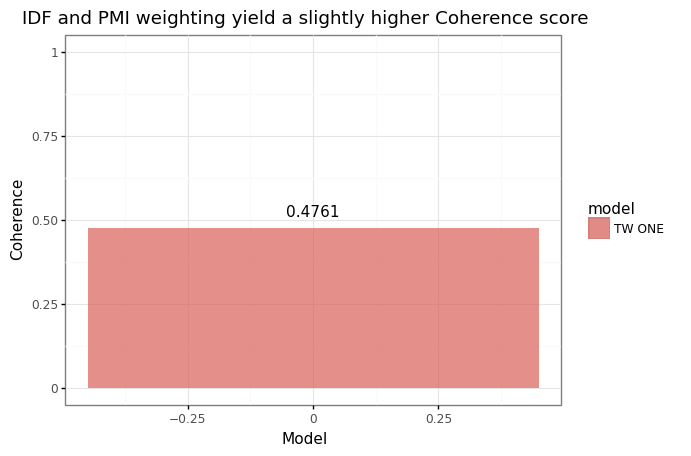

<ggplot: (8780870458125)>

In [16]:
df_coherence = pd.DataFrame(coherence_scores).T
df_coherence.columns = ["TW ONE"]
df_coherence= df_coherence.melt(var_name="model").round(4)
df_coherence.reset_index(inplace=True)
df_coherence.to_pickle('data/hdp_coherence_scores.pkl')

(ggplot(df_coherence) +
 geom_bar(aes(x='index', y="value", fill="model"), 
          stat="identity", alpha=0.7) +
 geom_text(aes(x="index",y=df_coherence.value.values +0.05, label="value")) +
 theme_bw() +
 lims(y=(0,1)) +
 labs(y="Coherence", x="Model", title="IDF and PMI weighting yield a slightly higher Coherence score") 
)

In [7]:
# Uploaded the df for the above code to data folder
tweets_processed_df = pd.read_pickle('data/tweets_processed.pkl')
df_coherence = pd.read_pickle('data/hdp_coherence_scores.pkl')

id2word_stemmed = corpora.Dictionary(tweets_processed_df['stemmed'])
id2word_stemmed.filter_extremes(no_below=10)
corpus_stemmed = [id2word_stemmed.doc2bow(tweet) for tweet in tweets_processed_df['stemmed']]


In [8]:
id2word_stemmed = corpora.Dictionary(tweets_processed_df['stemmed'])
id2word_stemmed.filter_extremes(no_below=10)
corpus_stemmed = [id2word_stemmed.doc2bow(tweet) for tweet in tweets_processed_df['stemmed']]


In [9]:
import os

os.environ.update({'MALLET_PATH':r'Users/austingerner/mallet-2.0.8/'})
mallet_path = '/Users/austingerner/mallet-2.0.8/bin/mallet.bat'

# Coherence Score

In [10]:
import os

os.environ.update({'MALLET_PATH':r'Users/austingerner/mallet-2.0.8/'})
mallet_path = '/Users/austingerner/mallet-2.0.8/bin/mallet'

def save_computed_models(model_list):
    model_number = 5
    for i in model_list:
        print(i)
        i.save("models/topic-model-number-topics"+str(model_number)+".txt")
        model_number+=5
    
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        print("start, limit, step", start, limit, step, num_topics)

        lda = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word_stemmed)
        coherence_lda = CoherenceModel(model=lda, dictionary=id2word_stemmed, texts=tweets_processed_df['stemmed'], coherence='c_v')
        
        model_list.append(lda)
        coherencemodel = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    print("coherence_values", coherence_values)
    save_computed_models(model_list)
    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word_stemmed, texts=tweets_processed_df['stemmed'], corpus=corpus_stemmed, start=46, limit=86, step=5)




start, limit, step 46 86 5 46
start, limit, step 46 86 5 51
start, limit, step 46 86 5 56
start, limit, step 46 86 5 61
start, limit, step 46 86 5 66
start, limit, step 46 86 5 71
start, limit, step 46 86 5 76
start, limit, step 46 86 5 81
coherence_values [0.4714792199700144, 0.47043945142710386, 0.4680998886158139, 0.46809218211215814, 0.4769792670569796, 0.4777835430773755, 0.48812708042082653, 0.4771847005118435]


NameError: name 'stop' is not defined

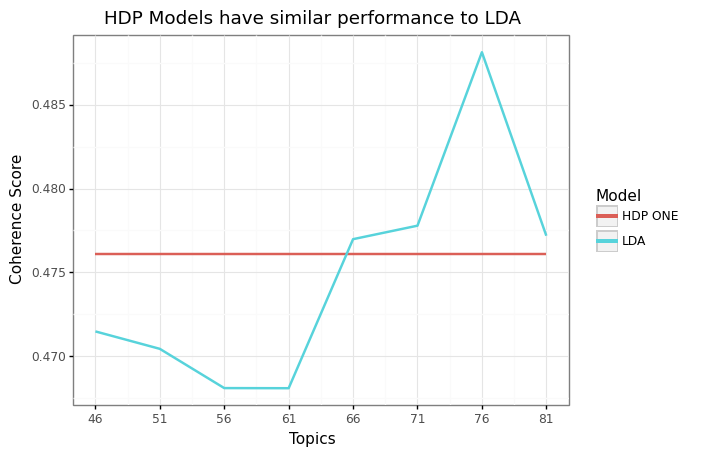

<ggplot: (8767399674043)>

In [11]:
topics = list(range(46,85,5))
idf_coherence = df_coherence.value

df = pd.DataFrame([topics, coherence_values]).T

for v in idf_coherence:
    vals = pd.Series(np.repeat(v, len(topics)))
    df = pd.concat([df, vals], axis=1)

df.columns = ["topics", "LDA", "HDP ONE"]
df_melt = df.melt(id_vars=["topics"], var_name="Model")

(ggplot(df_melt, aes(x='topics', y='value', color='Model')) +
 geom_line(size=1) +
 labs(x = 'Topics', y="Coherence Score", title="HDP Models have similar performance to LDA")+
 theme_bw() +
 scale_x_continuous(breaks = topics)
)

# Mallet Model

In [12]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_stemmed,
                               id2word = id2word_stemmed,
                               num_topics=76,
                               random_state=100,
                               update_every=1,
                               chunksize=100,
                               passes=4,
                               alpha=[0.01]*num_topics,
                            eta=[0.01]*len(id2word_stemmed.keys()),
                               per_word_topics=True)


In [7]:
model_topics_76 = gensim.utils.SaveLoad.load('/Users/austingerner/Documents/gw/capstone/modeling/lda/models/topic-model-number-topics76.txt') 
model_topics_76 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model_topics_76)


In [19]:
vis = pyLDAvis.gensim.prepare(topic_model=model_topics_76, corpus=corpus_stemmed, dictionary=id2word_stemmed)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

/Applications/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
/Applications/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
/Applications/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log


# Topic Distribution per tweet - LDA Mallet

In [29]:
tweets_processed_df = pd.read_pickle('data/tweets_processed.pkl')
# df_coherence = pd.read_pickle('data/hdp_coherence_scores.pkl')
# tweet_topics_corpus_df = pd.to_pickle("data/tweets_topic_distribution.pkl")

id2word_stemmed = corpora.Dictionary(tweets_processed_df['stemmed'])
id2word_stemmed.filter_extremes(no_below=10)
corpus_stemmed = [id2word_stemmed.doc2bow(tweet) for tweet in tweets_processed_df['stemmed']]
tweets_processed_df['new_tweets_corpus'] =  [id2word_stemmed.doc2bow(text) for text in tweets_processed_df['tokens_no_stop']]

tweet_topics_corpus_df.drop_duplicates(subset ="id", 
                     keep = 'first', inplace = True)
tweets_processed_df['created_at_month'] = pd.DatetimeIndex(tweets_processed_df['created_at']).month
tweet_topics_corpus_df.head()

,id,created_at_month,text,topic_76
0,1252570534250008577,4,#GASB's proposal postpones almost all Statement and Implementation Guide effective dates for fiscal years 2019 and… https://t.co/ohIGhlOpAz,33
1,1303414058255675392,9,"@UNICEF will lead global procurement &amp; supply of #COVID19 vaccines for #COVAX, the World Health Organization (@WHO)… https://t.co/1gzepELKrK",11
2,1303414058255675392,9,"@UNICEF will lead global procurement &amp; supply of #COVID19 vaccines for #COVAX, the World Health Organization (@WHO)… https://t.co/1gzepELKrK",11
3,1248188906148892673,4,Are you looking for important information on how to ease capacity constraints and deal with patient flow issues fro… https://t.co/9L03iHK8sN,65
4,1282149524442472448,7,Why is #quarantine having me watch shows I normally wouldn’t watch? \n#CloseEnoughMAX #sip2020 #streaming #COVID19,0


In [15]:
tweet_topics_corpus_df = tweets_processed_df[["id", "created_at_month", "text", "new_tweets_corpus"]]
tweet_topics_corpus_df['vector_76'] =  model_topics_76[tweet_topics_corpus_df['new_tweets_corpus']]
tweet_topics_corpus_df['topic_76'] = tweet_topics_corpus_df.vector_76.apply(lambda x: highestRank(x))

tweet_topics_corpus_df = tweet_topics_corpus_df.drop(columns=['vector_76'])
tweet_topics_corpus_df = tweet_topics_corpus_df.drop(columns=['new_tweets_corpus'])
tweet_topics_corpus_df.to_pickle('data/tweets_topic_distribution.pkl')


/Applications/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<ipython-input-15-277c0da94f8f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-15-277c0da94f8f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Prevelant Topics - LDA GENSIM MODEL

In [132]:
dominant_topic_df = tweet_topics_corpus_df.groupby('topic_76').agg(
                                  Doc_Count = ('topic_76', np.size),
                                  Total_Docs_Perc = ('topic_76', np.size)).reset_index()

dominant_topic_df['Total_Docs_Perc'] = dominant_topic_df['Total_Docs_Perc'].apply(lambda row: round((row*100) / len(corpus_stemmed), 2))

dominant_topic_df = dominant_topic_df.sort_values(by='topic_76', ascending=True)
# dominant_topic_df
dominant_topic_df = dominant_topic_df.sort_values(by='topic_76', ascending=True)
dominant_topic_df.sort_values(by='Total_Docs_Perc', ascending=False).head(20)

,topic_76,Doc_Count,Total_Docs_Perc
27,27,72782,1.58
66,66,68740,1.49
17,17,65381,1.42
26,26,60673,1.32
23,23,59742,1.30
12,12,54432,1.18
5,5,49748,1.08
25,25,48378,1.05
9,9,48315,1.05
20,20,46780,1.01


In [250]:
top_20_dominant_topics_df = tweet_topics_corpus_df.loc[(tweet_topics_corpus_df.topic_76 == 27) |
                           (tweet_topics_corpus_df.topic_76 == 66) |
                           (tweet_topics_corpus_df.topic_76 == 17) |
                           (tweet_topics_corpus_df.topic_76 == 26) |
                           (tweet_topics_corpus_df.topic_76 == 23) |
                           (tweet_topics_corpus_df.topic_76 == 12) |
                           (tweet_topics_corpus_df.topic_76 == 5) |
                           (tweet_topics_corpus_df.topic_76 == 25) |
                           (tweet_topics_corpus_df.topic_76 == 9) |
                           (tweet_topics_corpus_df.topic_76 == 20)]


In [251]:
# Group by year and topic, counting the number of documents per topic per year.
prevelant_tweet_topic_distribution = top_20_dominant_topics_df.copy()
prevelant_tweet_topic_distribution.drop_duplicates(subset ="id", 
                     keep = 'first', inplace = True)

max_counts = prevelant_tweet_topic_distribution[['id','created_at_month', 'topic_76']].groupby(['created_at_month', 'topic_76']).agg({'topic_76': 'count'}).rename(columns={'topic_76': 'max_count'}).reset_index()

# Count the number of individual documents per year
total_docs = prevelant_tweet_topic_distribution[['id','created_at_month', 'topic_76']].groupby(['created_at_month']).agg({'topic_76' : 'count'}).reset_index()

# Combine the two dataframes
max_counts = max_counts.merge(total_docs, on='created_at_month', how='left').rename(columns={'topic_76_x': 'topic_id','topic_76_y': 'total_docs'})

max_counts['prevalence'] = max_counts['max_count']/max_counts['total_docs']
max_counts = max_counts.drop(columns=['max_count', 'total_docs'])



In [252]:
max_counts_topics = max_counts.pivot(index='created_at_month', columns='topic_id', values='prevalence')

In [253]:
max_counts.head()

,created_at_month,topic_id,prevalence
0,3,5,0.091384
1,3,9,0.101506
2,3,12,0.131055
3,3,17,0.118365
4,3,20,0.116681


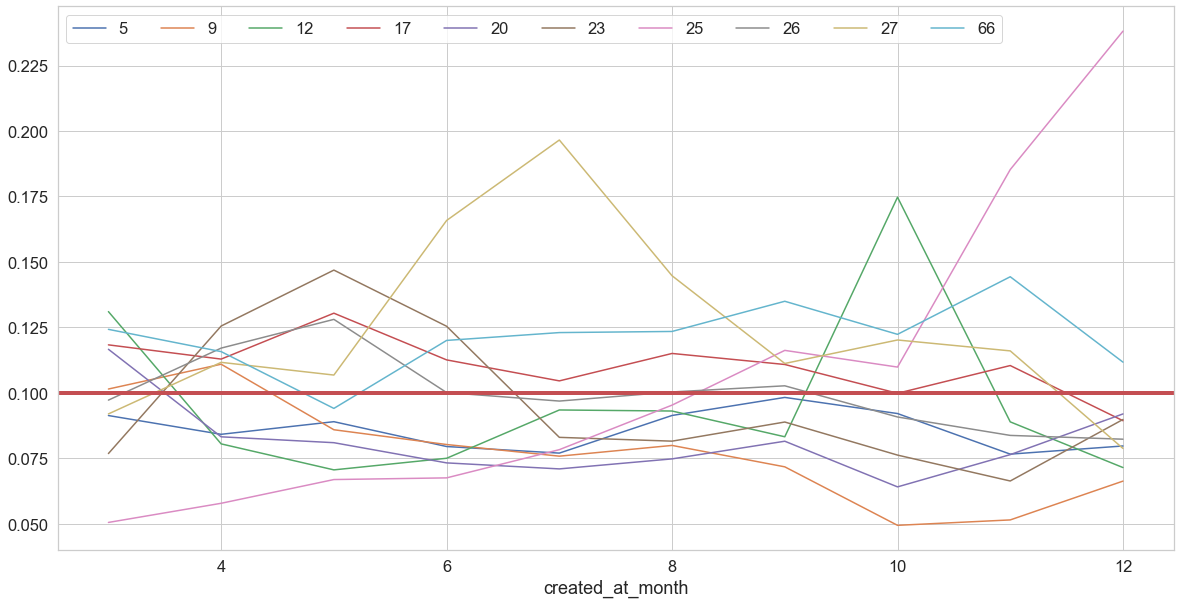

In [255]:
max_counts_topics.plot(figsize=(20,10))
plt.legend(loc="upper left", ncol=len(max_counts_topics.columns))
plt.axhline(y=max_counts["prevalence"].mean(), linewidth=4, color='r', label="Avg. Perc%")




In [96]:
tweet_topics_corpus_df = pd.merge(tweet_topics_corpus_df, max_counts, how='left', left_on=['created_at_month', 'topic_76',], right_on = ['created_at_month', 'topic_id'])




In [266]:
tweets_topic_distribution_location_df.shape

(2850903, 22)

In [260]:
tweets_topic_distribution_location_df = pd.merge(tweets_processed_df, tweet_topics_corpus_df, how='left', left_on=['id', 'created_at_month'], right_on = ['id','created_at_month'])

tweets_topic_distribution_location_df = tweets_topic_distribution_location_df.drop(columns = ['text_y', 'topic_76'])

tweets_topic_distribution_location_df.drop_duplicates(subset ="id", 
                     keep = 'first', inplace = True)

In [265]:
tweets_topic_distribution_location_df.drop_duplicates(subset ="id", 
                     keep = 'first', inplace = True)

In [267]:
tweets_topic_distribution_location_df.to_pickle("data/tweet_topic_distribution_location.pkl")

In [ ]:
tweets_topic_distribution_location_df = pd.read_pickle("data/tweet_topic_distribution_location.pkl")